In [177]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchmetrics import R2Score

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter
import pytorch_forecasting as pyf

from src.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(17)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
G = nx.readwrite.read_gpickle('data/network32.gpickle')

In [179]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_data = from_networkx(G, group_node_attrs=['embedding'])
pyg_data.to(device);

In [180]:
df = pd.read_csv('data/mta_ridership_pivot.csv')
df['group'] = 0
df

,1 AV,103 ST,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,14 ST,145 ST,...,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,YORK ST,ZEREGA AV,weekday,time_idx,group
0,191.0,317.0,20.0,239.0,70.0,84.0,216.0,782.0,414.0,212.0,...,35.0,299.0,224.0,800.0,362.0,7309.0,44.0,5,0,0
1,159.0,366.0,19.0,229.0,87.0,65.0,213.0,822.0,346.0,211.0,...,20.0,253.0,188.0,696.0,349.0,447.0,47.0,6,1,0
2,310.0,662.0,36.0,399.0,145.0,139.0,407.0,1226.0,773.0,333.0,...,55.0,478.0,542.0,1079.0,663.0,867.0,100.0,0,2,0
3,390.0,678.0,54.0,368.0,157.0,157.0,420.0,1187.0,752.0,394.0,...,48.0,461.0,573.0,1430.0,686.0,896.0,123.0,1,3,0
4,402.0,680.0,50.0,407.0,143.0,177.0,445.0,1116.0,756.0,411.0,...,52.0,454.0,538.0,1195.0,696.0,894.0,121.0,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,594.0,916.0,463.0,579.0,372.0,156.0,273.0,1741.0,1176.0,624.0,...,62.0,593.0,762.0,2268.0,875.0,1430.0,199.0,0,359,0
360,629.0,856.0,513.0,504.0,180.0,176.0,256.0,1699.0,1147.0,595.0,...,75.0,545.0,761.0,1724.0,872.0,1487.0,193.0,1,360,0
361,669.0,886.0,467.0,458.0,325.0,157.0,246.0,677.0,1089.0,586.0,...,71.0,566.0,797.0,465.0,769.0,1418.0,203.0,2,361,0
362,585.0,803.0,441.0,511.0,363.0,116.0,241.0,1043.0,1001.0,577.0,...,67.0,513.0,724.0,1669.0,767.0,1349.0,185.0,3,362,0


In [181]:
stations = df.columns[1:-3].to_list()
targets = df.columns[1:-3].to_list()
# targets are just stations ridership
features = targets
# days and local features can be added

In [310]:
from locale import normalize

from sklearn.preprocessing import StandardScaler


class StandardScaler:
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)


class TimeSeriesDataset(Dataset):
    def __init__(self, data: pd.DataFrame, features_cols, target_cols, encoder_length=14, 
        horizon_length=1, normalize=True):
        self.X = torch.tensor(data[features_cols].values, dtype=torch.float32)
        self.y = torch.tensor(data[target_cols].values, dtype=torch.float32)

        self.window = encoder_length
        self.horizon = horizon_length
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

        if normalize:
            self.normalize()
    
    def normalize(self):
        self.X = StandardScaler().fit_transform(self.X)
        self.y = StandardScaler().fit_transform(self.y)

    def __getitem__(self, index):
        x = self.X[index: index + self.window]
        y = self.y[index + self.window: index + self.window + self.horizon]
        return x, y.reshape(-1)

    def __len__(self):
        return len(self.X) - self.window - self.horizon 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [311]:
dataset = TimeSeriesDataset(df, features, targets)
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([14, 226]), torch.Size([226]))

In [312]:
def make_dataloaders(df, batch_size=64, **kwargs):
    train_df = df.iloc[:int(len(df) * 0.7)]
    val_df = df.iloc[int(len(df) * 0.7): int(len(df) * 0.85)]
    test_df = df.iloc[int(len(df) * 0.85):]

    train_ds = TimeSeriesDataset(train_df, features, targets, **kwargs)
    val_ds = TimeSeriesDataset(val_df, features, targets, **kwargs)
    test_ds = TimeSeriesDataset(test_df, features, targets, **kwargs)


    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

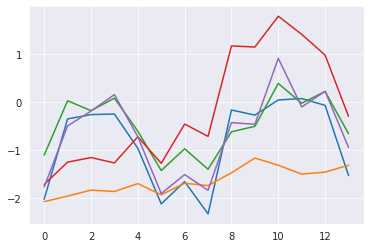

In [322]:
loader, _, _ = make_dataloaders(df, batch_size=4, normalize=True)
kek = [x.shape for x in next(iter(loader))]
plt.plot(next(iter(loader))[0][0, :, :5].detach().numpy())
plt.show()

In [271]:
pyg_data = pyg_data.subgraph(torch.tensor([pyg_data.id.index(x) for x in stations]))
pyg_data.id = stations

In [283]:
from statistics import mean

def test(model, loader, loss_fn, score_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    losses = []

    outs, ys = [], []
    with torch.no_grad():
        for X, y in loader:
            X_gpu, y_gpu = X.to(device), y.to(device)
            out = model(X_gpu)

            outs.append(out)
            ys.append(y_gpu)

            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
    
    ys = torch.vstack(ys)
    outs = torch.vstack(outs)
    scores = [score_fn(ys[day], outs[day]).item() for day in range(len(ys))]
    return mean(losses), mean(scores)


def train(model, train_loader, val_loader,
    loss_fn, score_fn, optimizer, device, scheduler=None, num_epochs=10, plot=True, plot_update_freq=5):
    """ returns best model on validation
    """

    train_losses = []
    val_losses = []
    val_scores = []

    best_val_score = -torch.inf
    best_model = None

    for epoch in range(num_epochs + 1):
        model.train()
        losses = []
        for X, y in train_loader:
            X_gpu, y_gpu = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X_gpu)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
            # loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step()

        train_losses.append(mean(losses))
        val_loss, val_score = test(model, val_loader, loss_fn, score_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if val_score > best_val_score:
            best_val_score = val_score
            best_model = copy.deepcopy(model)

        if plot and epoch > 0 and epoch % plot_update_freq == 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=train_losses, label='Train', color='blue')
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=val_losses, label='Val', color='red')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=val_scores, label='Val', color='red')
            # sns.lineplot(ax=axes[1], x=range(epoch + 1), y=train_scores, label='Train', color='blue')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
        
        # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
    return best_model

In [284]:
class MeanValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X):
        out = torch.mean(X, dim=1)
        return out

class LastValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X):
        out = X[:, -1]
        return out

class PreviousWeekValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X):
        out = X[:, -7]
        return out

In [285]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [302]:
NEIGHBORS_NUM = 25
loss_fn = nn.MSELoss().to(device)
score = R2Score().to(device)
train_loader, val_loader, test_loader = make_dataloaders(df, batch_size=4, normalize=False)


def run():
    results = dict()

    model = PreviousWeekValueModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-7)
        
    model = train(model, train_loader, val_loader,
        loss_fn, score, optimizer, device, num_epochs=10, plot=True, plot_update_freq=1)

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_loader, loss_fn, score, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return results

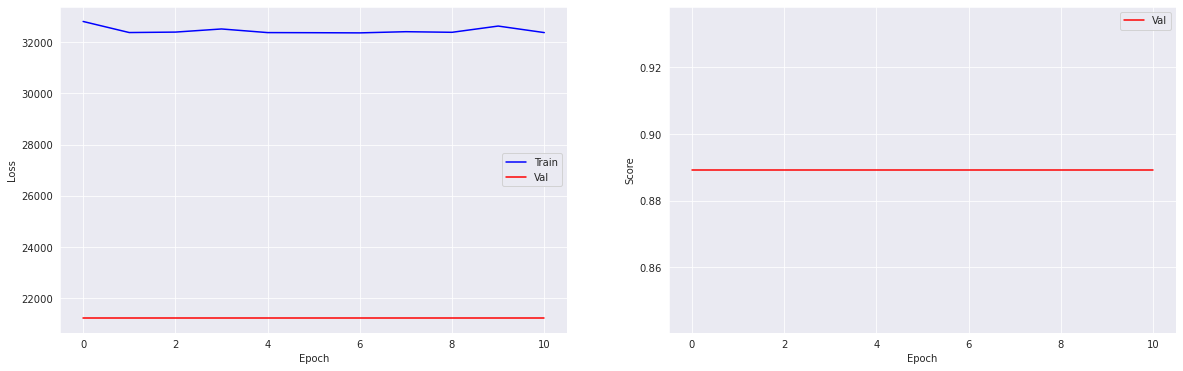

Type: PreviousWeekValueModel, Test loss: 38247.62, Test score: 0.6998


{'PreviousWeekValueModel': 0.6997862815856933}

In [303]:
run()

In [241]:
import json

extrapolation_mods = ['dist', 'cosine_sim', 'gat', 'gat_multihead']

# for mod in tqdm(extrapolation_mods):
#     with open(f'results/{mod}.json', mode='w') as f:
#         json.dump(run(mod), f, indent=4)